# PyMC Sampler Comparison: Cython (Metropolis) vs JAX (NUTS)

This notebook compares two approaches for Bayesian inference in the aDDM:

1. **Cython + Metropolis**: Custom PyTensor Op wrapping Cython likelihood (gradient-free)
2. **JAX + NUTS**: JAX-based likelihood with automatic differentiation (gradient-based)

The key insight is that the JAX implementation provides gradients via autodiff, enabling the use of NUTS (No-U-Turn Sampler), which is generally much more efficient than Metropolis-Hastings for continuous parameters.

In [1]:
import os
import sys
import time
import datetime
import pickle
import numpy as np

# Add src to path
src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

from pytensor.graph.op import Op

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

print(f"PyMC version: {pm.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

PyMC version: 5.27.0
JAX version: 0.7.2
JAX devices: [CpuDevice(id=0)]


## Configuration

In [2]:
# =====================================================================
# Configuration
# =====================================================================
DATA_PATH = "example4_new/addm_data_20251015-163921.pkl"

# Data subset (use smaller for testing, larger for real comparison)
NUM_TRIALS = 500  # Number of trials to use

# Sampling configuration
N_DRAWS = 500      # Number of posterior draws per chain
N_TUNE = 200       # Number of tuning steps
N_CHAINS = 2       # Number of chains

# Cython configuration
NUM_THREADS = 8    # OpenMP threads for Cython

# JAX configuration  
TRUNC_NUM = 6      # Series truncation (6 is optimal for JAX/XLA)

# Optional: keep BLAS single-threaded so comparisons are fair
# AF-COMMENT: Do this later, right now more interested in honest performance on
# same machine unrestrained
# os.environ.setdefault("MKL_NUM_THREADS", "1")
# os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")

# Random seed for reproducibility
RANDOM_SEED = 42

## Load Data

In [3]:
# =====================================================================
# Load and prepare data
# =====================================================================
data = pickle.load(open(DATA_PATH, "rb"))

# True parameters
TRUE_PARAMS = {
    'eta': float(data["eta"]),
    'kappa': float(data["kappa"]),
    'a': float(data["a"]),
    'b': float(data["b"]),
    'x0': float(data["x0"]),
    'sigma': float(data["sigma"]),
}

# Extract data arrays
r1_full = data["r1_data"]
r2_full = data["r2_data"]
flag_full = data["flag_data"].astype(np.int32)
sacc_full = data["sacc_array_padded_data"].astype(np.float64)
length_full = data["d_data"].astype(np.int32)
rt_full = data["decision_data"][:, 0].astype(np.float64)
choice_full = data["decision_data"][:, 1].astype(np.int32)

num_data_full, max_d = sacc_full.shape

# Subset to NUM_TRIALS
idx = slice(0, min(NUM_TRIALS, num_data_full))
r1_data = r1_full[idx]
r2_data = r2_full[idx]
flag_data = flag_full[idx]
sacc_data = sacc_full[idx]
length_data = length_full[idx]
rt_data = rt_full[idx]
choice_data = choice_full[idx]

num_data = len(rt_data)
sigma = TRUE_PARAMS['sigma']
M = float(np.max(rt_data))  # Max RT for constraints

print(f"Data loaded: {num_data} trials, max_d={max_d}")
print(f"Max RT: {M:.4f}")
print(f"\nTrue parameters:")
for k, v in TRUE_PARAMS.items():
    print(f"  {k}: {v}")

Data loaded: 500 trials, max_d=12
Max RT: 4.8855

True parameters:
  eta: 0.7
  kappa: 0.5
  a: 2.1
  b: 0.3
  x0: -0.2
  sigma: 1.0


## 1. Cython Implementation (Gradient-Free)

This uses a custom PyTensor Op that wraps the Cython likelihood function. Since there's no gradient information, we must use gradient-free samplers like Metropolis-Hastings.

In [4]:
# Import Cython implementation
from efficient_fpt.multi_stage_cy import compute_loss_parallel, print_num_threads
from efficient_fpt.utils import get_alternating_mu_array

print("Cython implementation loaded.")
print_num_threads()

Cython implementation loaded.
Number of available threads: 12


In [5]:
class LogLikeCython(Op):
    """
    PyTensor Op wrapping the Cython likelihood function.
    
    Input: theta = [eta, kappa, a, b, x0]
    Output: scalar log-likelihood
    
    NOTE: No grad() method defined = gradient-free only!
    """
    itypes = [pt.dvector]
    otypes = [pt.dscalar]

    def __init__(self, rt_data, choice_data, r1_data, r2_data, flag_data,
                 sacc_data, length_data, max_d, sigma, num_threads=8):
        self.rt_data = np.asarray(rt_data, dtype=np.float64)
        self.choice_data = np.asarray(choice_data, dtype=np.int32)
        self.r1_data = np.asarray(r1_data, dtype=np.float64)
        self.r2_data = np.asarray(r2_data, dtype=np.float64)
        self.flag_data = np.asarray(flag_data, dtype=np.int32)
        self.sacc_data = np.asarray(sacc_data, dtype=np.float64)
        self.length_data = np.asarray(length_data, dtype=np.int32)
        self.max_d = int(max_d)
        self.sigma = float(sigma)
        self.num_data = len(self.rt_data)
        self.num_threads = int(num_threads)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        eta, kappa, a, b, x0 = theta

        # Compute drift rates from eta, kappa
        mu1_data = kappa * (self.r1_data - eta * self.r2_data)
        mu2_data = kappa * (eta * self.r1_data - self.r2_data)

        # Compute negative log-likelihood
        nll = compute_loss_parallel(
            mu1_data, mu2_data,
            self.rt_data, self.choice_data, self.flag_data,
            self.sacc_data, self.length_data, self.max_d,
            self.sigma, a, b, x0,
            num_threads=self.num_threads,
        )
        
        # Return log-likelihood (negative of NLL)
        loglik = -self.num_data * nll
        outputs[0][0] = np.array(loglik, dtype="float64")


# Create the Cython Op
cython_loglike_op = LogLikeCython(
    rt_data=rt_data, choice_data=choice_data,
    r1_data=r1_data, r2_data=r2_data, flag_data=flag_data,
    sacc_data=sacc_data, length_data=length_data, max_d=max_d,
    sigma=sigma, num_threads=NUM_THREADS,
)

# Test it
theta_true = np.array([TRUE_PARAMS['eta'], TRUE_PARAMS['kappa'], 
                       TRUE_PARAMS['a'], TRUE_PARAMS['b'], TRUE_PARAMS['x0']])
theta_sym = pt.dvector("theta")
ll_cython = pytensor.function([theta_sym], cython_loglike_op(theta_sym))

print(f"Cython log-likelihood at true params: {ll_cython(theta_true):.4f}")

Cython log-likelihood at true params: -749.6751


## 2. JAX Implementation (With Gradients)

This uses the JAX-based likelihood which supports automatic differentiation. We create a custom PyTensor Op that also implements the gradient, enabling NUTS sampling.

In [6]:
# Import JAX implementation
from efficient_fpt_jax.multi_stage import get_addm_fptd_jax_fast, pad_sacc_array_safely

print("JAX implementation loaded.")

JAX implementation loaded.


In [7]:
# Convert data to JAX arrays
jax_rt = jnp.array(rt_data)
jax_choice = jnp.array(choice_data)
jax_d = jnp.array(length_data)
jax_r1 = jnp.array(r1_data)
jax_r2 = jnp.array(r2_data)
jax_flag = jnp.array(flag_data)
jax_sacc = jnp.array(sacc_data)

# Pre-compute safe saccade arrays (avoids NaN in gradients)
print("Pre-computing safe saccade arrays...")
jax_sacc_safe = vmap(lambda s, d: pad_sacc_array_safely(s, d, max_d))(jax_sacc, jax_d)
print("Done.")

Pre-computing safe saccade arrays...
Done.


In [8]:
def compute_mu_arrays_jax(eta, kappa, r1, r2, flag, max_d):
    """
    Compute mu arrays for all trials given parameters.
    
    For flag=0: [mu1, mu2, mu1, mu2, ...]
    For flag=1: [mu2, mu1, mu2, mu1, ...]
    """
    mu1 = kappa * (r1 - eta * r2)
    mu2 = kappa * (eta * r1 - r2)
    
    # Build alternating pattern
    indices = jnp.arange(max_d)
    # When flag=0: even indices (where indices%2==0==flag) get mu1, odd get mu2
    # When flag=1: even indices (where indices%2==0!=flag) get mu2, odd get mu1
    mu_array = jnp.where(
        (indices % 2) == flag,
        mu1,  # True when index parity matches flag
        mu2   # False otherwise
    )
    return mu_array


def jax_loglik_single(rt, choice, d, r1, r2, flag, sacc_safe, 
                      eta, kappa, a, b, x0, sigma, max_d, trunc_num):
    """Compute log-likelihood for a single trial."""
    mu_array = compute_mu_arrays_jax(eta, kappa, r1, r2, flag, max_d)
    
    # Compute FPTD
    fptd = get_addm_fptd_jax_fast(
        rt, d, mu_array, sacc_safe, sigma, a, b, x0, choice,
        order=30, trunc_num=trunc_num, safe_sacc=sacc_safe
    )
    
    # Return log-likelihood (with floor to avoid log(0))
    return jnp.log(jnp.maximum(fptd, 1e-30))


def jax_loglik_batch(eta, kappa, a, b, x0):
    """
    Compute total log-likelihood for all trials.
    
    This function is JIT-compiled and differentiable.
    """
    # Vectorize over trials
    loglik_fn = vmap(
        lambda rt, choice, d, r1, r2, flag, sacc_safe: jax_loglik_single(
            rt, choice, d, r1, r2, flag, sacc_safe,
            eta, kappa, a, b, x0, sigma, max_d, TRUNC_NUM
        )
    )
    
    logliks = loglik_fn(jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe)
    return jnp.sum(logliks)


# JIT compile
jax_loglik_jit = jit(jax_loglik_batch)

# Also compile the gradient function
jax_grad_loglik = jit(grad(jax_loglik_batch, argnums=(0, 1, 2, 3, 4)))

# Warm up JIT
print("Warming up JAX JIT compilation...")
_ = jax_loglik_jit(TRUE_PARAMS['eta'], TRUE_PARAMS['kappa'], 
                   TRUE_PARAMS['a'], TRUE_PARAMS['b'], TRUE_PARAMS['x0'])
_ = jax_grad_loglik(TRUE_PARAMS['eta'], TRUE_PARAMS['kappa'],
                    TRUE_PARAMS['a'], TRUE_PARAMS['b'], TRUE_PARAMS['x0'])
print("Done.")

# Test
ll_jax = jax_loglik_jit(TRUE_PARAMS['eta'], TRUE_PARAMS['kappa'],
                        TRUE_PARAMS['a'], TRUE_PARAMS['b'], TRUE_PARAMS['x0'])
print(f"JAX log-likelihood at true params: {float(ll_jax):.4f}")

Warming up JAX JIT compilation...
Done.
JAX log-likelihood at true params: -749.6751


In [9]:
from pytensor.link.jax.dispatch import jax_funcify

class LogLikeJAX(Op):
    """
    PyTensor Op wrapping the JAX likelihood function WITH GRADIENTS.
    
    This enables NUTS sampling by providing gradient information.
    """
    itypes = [pt.dvector]
    otypes = [pt.dscalar]

    def __init__(self, loglik_fn, grad_fn):
        self.loglik_fn = loglik_fn
        self.grad_fn = grad_fn

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        eta, kappa, a, b, x0 = theta
        
        # Compute log-likelihood using JAX
        loglik = float(self.loglik_fn(eta, kappa, a, b, x0))
        outputs[0][0] = np.array(loglik, dtype="float64")

    def grad(self, inputs, output_grads):
        """Compute gradient using JAX autodiff."""
        (theta,) = inputs
        (g_out,) = output_grads
        
        # Use custom gradient Op
        grads = LogLikeJAXGrad(self.grad_fn)(theta)
        
        # Chain rule: multiply by output gradient
        return [g_out * grads]


class LogLikeJAXGrad(Op):
    """
    Gradient Op for the JAX likelihood.
    """
    itypes = [pt.dvector]
    otypes = [pt.dvector]

    def __init__(self, grad_fn):
        self.grad_fn = grad_fn

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        eta, kappa, a, b, x0 = theta
        
        # Compute gradients using JAX
        grads = self.grad_fn(eta, kappa, a, b, x0)
        grad_array = np.array([float(g) for g in grads], dtype="float64")
        outputs[0][0] = grad_array


# Register JAX implementations for our custom Ops
# This allows numpyro/blackjax backends to use them
@jax_funcify.register(LogLikeJAX)
def jax_funcify_LogLikeJAX(op, **kwargs):
    """Convert LogLikeJAX Op to a pure JAX function."""
    loglik_fn = op.loglik_fn
    
    def loglik_jax(theta):
        eta, kappa, a, b, x0 = theta[0], theta[1], theta[2], theta[3], theta[4]
        return loglik_fn(eta, kappa, a, b, x0)
    
    return loglik_jax


@jax_funcify.register(LogLikeJAXGrad)
def jax_funcify_LogLikeJAXGrad(op, **kwargs):
    """Convert LogLikeJAXGrad Op to a pure JAX function."""
    grad_fn = op.grad_fn
    
    def grad_jax(theta):
        eta, kappa, a, b, x0 = theta[0], theta[1], theta[2], theta[3], theta[4]
        grads = grad_fn(eta, kappa, a, b, x0)
        return jnp.stack(grads)
    
    return grad_jax


# Create the JAX Op with gradients
jax_loglike_op = LogLikeJAX(jax_loglik_jit, jax_grad_loglik)

# Test
ll_jax_op = pytensor.function([theta_sym], jax_loglike_op(theta_sym))
print(f"JAX Op log-likelihood at true params: {ll_jax_op(theta_true):.4f}")

# Test gradient
grad_sym = pt.grad(jax_loglike_op(theta_sym), theta_sym)
grad_fn = pytensor.function([theta_sym], grad_sym)
print(f"JAX Op gradients at true params: {grad_fn(theta_true)}")

JAX Op log-likelihood at true params: -749.6751
JAX Op gradients at true params: [20.12909758 -7.16946261 -8.24156236 -4.32972    -2.82183503]


## 3. Compare Likelihood Evaluation Speed

In [10]:
def time_fn(fn, *args, n=20):
    """Time a function over n calls."""
    start = time.perf_counter()
    for _ in range(n):
        _ = fn(*args)
    elapsed = time.perf_counter() - start
    return elapsed / n

print("=" * 60)
print("Likelihood Evaluation Timing")
print("=" * 60)

# Cython timing
t_cython = time_fn(ll_cython, theta_true, n=20)
print(f"Cython:        {t_cython*1000:.2f} ms per evaluation")

# JAX timing (likelihood only)
t_jax = time_fn(lambda t: float(jax_loglik_jit(t[0], t[1], t[2], t[3], t[4])), theta_true, n=20)
print(f"JAX (loglik):  {t_jax*1000:.2f} ms per evaluation ({t_cython/t_jax:.1f}x vs Cython)")

# JAX timing (likelihood + gradient)
def jax_loglik_and_grad(theta):
    ll = jax_loglik_jit(theta[0], theta[1], theta[2], theta[3], theta[4])
    g = jax_grad_loglik(theta[0], theta[1], theta[2], theta[3], theta[4])
    return ll, g

t_jax_grad = time_fn(jax_loglik_and_grad, theta_true, n=20)
print(f"JAX (+grad):   {t_jax_grad*1000:.2f} ms per evaluation")

Likelihood Evaluation Timing
Cython:        4.84 ms per evaluation
JAX (loglik):  29.25 ms per evaluation (0.2x vs Cython)
JAX (+grad):   44.79 ms per evaluation


## 4. Build PyMC Models

In [11]:
def build_pymc_model(loglike_op, name_suffix=""):
    """
    Build a PyMC model with the given likelihood Op.
    
    Priors are chosen to be weakly informative but proper.
    """
    with pm.Model() as model:
        # eta: attention discount factor in [0, 1]
        eta = pm.Beta(f"eta{name_suffix}", alpha=2.0, beta=2.0)
        
        # kappa: drift scaling (positive)
        kappa = pm.Gamma(f"kappa{name_suffix}", alpha=2.0, beta=4.0)
        
        # a: initial boundary (positive)
        a = pm.Gamma(f"a{name_suffix}", alpha=4.0, beta=2.0)
        
        # b: boundary collapse rate (constrained so boundary doesn't collapse before max RT)
        # b must satisfy: a - b*M > 0, i.e., b < a/M
        b_raw = pm.Beta(f"b_raw{name_suffix}", alpha=2.0, beta=2.0)
        b = pm.Deterministic(f"b{name_suffix}", b_raw * a / M * 0.95)  # 0.95 for safety margin
        
        # x0: starting position (between -a and a)
        x0_raw = pm.Beta(f"x0_raw{name_suffix}", alpha=2.0, beta=2.0)
        x0 = pm.Deterministic(f"x0{name_suffix}", -a + 2.0 * a * x0_raw)
        
        # Stack parameters for the likelihood Op
        theta = pt.stack([eta, kappa, a, b, x0])
        
        # Add likelihood as a Potential
        pm.Potential(f"loglik{name_suffix}", loglike_op(theta))
    
    return model


print("Building PyMC models...")
model_cython = build_pymc_model(cython_loglike_op, "_cy")
model_jax = build_pymc_model(jax_loglike_op, "_jax")
print("Done.")

Building PyMC models...
Done.


## 5. Run Cython + Metropolis Sampling

In [12]:
print("=" * 60)
print("Cython + Metropolis Sampling")
print("=" * 60)
print(f"Configuration: {N_DRAWS} draws, {N_TUNE} tune, {N_CHAINS} chains")
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")

with model_cython:
    t_start = time.perf_counter()
    
    trace_cython = pm.sample(
        draws=N_DRAWS,
        tune=N_TUNE,
        chains=N_CHAINS,
        cores=2,  # Single core (Cython uses OpenMP internally)
        step=pm.Metropolis(),
        random_seed=RANDOM_SEED,
        progressbar=True,
        return_inferencedata=True,
    )
    
    t_cython_sample = time.perf_counter() - t_start

print(f"\nFinished at: {datetime.datetime.now().strftime('%H:%M:%S')}")
print(f"Total sampling time: {t_cython_sample:.1f} s")
print(f"Time per sample: {t_cython_sample / (N_DRAWS * N_CHAINS) * 1000:.1f} ms")

Cython + Metropolis Sampling
Configuration: 500 draws, 200 tune, 2 chains
Started at: 02:17:15


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [eta_cy]
>Metropolis: [kappa_cy]
>Metropolis: [a_cy]
>Metropolis: [b_raw_cy]
>Metropolis: [x0_raw_cy]
/Users/afengler/miniconda3/envs/efficient-fpt/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/afengler/miniconda3/envs/efficient-fpt/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 2 chains for 200 tune and 500 draw iterations (400 + 1_000 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Finished at: 02:18:15
Total sampling time: 60.1 s
Time per sample: 60.1 ms


## 6. Run JAX + NUTS Sampling

Since we have gradients, we can use the much more efficient NUTS sampler!

In [13]:
print("=" * 60)
print("JAX + NUTS Sampling (numpyro backend)")
print("=" * 60)
print(f"Configuration: {N_DRAWS} draws, {N_TUNE} tune, {N_CHAINS} chains")
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")

with model_jax:
    t_start = time.perf_counter()
    
    # Use numpyro backend - our custom Op is registered via jax_funcify
    trace_jax = pm.sample(
        draws=N_DRAWS,
        tune=N_TUNE,
        chains=N_CHAINS,
        nuts_sampler="numpyro",
        random_seed=RANDOM_SEED,
        progressbar=True,
        return_inferencedata=True,
    )
    
    t_jax_sample = time.perf_counter() - t_start

print(f"\nFinished at: {datetime.datetime.now().strftime('%H:%M:%S')}")
print(f"Total sampling time: {t_jax_sample:.1f} s")
print(f"Time per sample: {t_jax_sample / (N_DRAWS * N_CHAINS) * 1000:.1f} ms")

JAX + NUTS Sampling (numpyro backend)
Configuration: 500 draws, 200 tune, 2 chains
Started at: 02:18:15


/Users/afengler/miniconda3/envs/efficient-fpt/lib/python3.12/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 700/700 [17:17<00:00,  1.48s/it, 7 steps of size 4.62e-01. acc. prob=0.94]    
We recommend running at least 4 chains for robust computation of convergence diagnostics



Finished at: 02:52:32
Total sampling time: 2057.0 s
Time per sample: 2057.0 ms


## 7. Compare Results

In [14]:
print("=" * 60)
print("Sampling Performance Comparison")
print("=" * 60)

print(f"\nCython + Metropolis:")
print(f"  Total time: {t_cython_sample:.1f} s")
print(f"  Time per sample: {t_cython_sample / (N_DRAWS * N_CHAINS) * 1000:.1f} ms")

print(f"\nJAX + NUTS:")
print(f"  Total time: {t_jax_sample:.1f} s")
print(f"  Time per sample: {t_jax_sample / (N_DRAWS * N_CHAINS) * 1000:.1f} ms")

print(f"\nSpeedup: {t_cython_sample / t_jax_sample:.2f}x")

Sampling Performance Comparison

Cython + Metropolis:
  Total time: 60.1 s
  Time per sample: 60.1 ms

JAX + NUTS:
  Total time: 2057.0 s
  Time per sample: 2057.0 ms

Speedup: 0.03x


In [15]:
# Rename variables for comparison
trace_cython_renamed = trace_cython.rename({
    'eta_cy': 'eta', 'kappa_cy': 'kappa', 'a_cy': 'a', 'b_cy': 'b', 'x0_cy': 'x0'
})
trace_jax_renamed = trace_jax.rename({
    'eta_jax': 'eta', 'kappa_jax': 'kappa', 'a_jax': 'a', 'b_jax': 'b', 'x0_jax': 'x0'
})

params = ['eta', 'kappa', 'a', 'b', 'x0']

print("\n" + "=" * 60)
print("Parameter Estimates Comparison")
print("=" * 60)

print(f"\n{'Param':<8} {'True':<10} {'Cython Mean':<12} {'JAX Mean':<12} {'Cython ESS':<12} {'JAX ESS':<12}")
print("-" * 68)

for param in params:
    true_val = TRUE_PARAMS[param]
    
    cy_mean = float(trace_cython_renamed.posterior[param].mean())
    jax_mean = float(trace_jax_renamed.posterior[param].mean())
    
    cy_ess = float(az.ess(trace_cython_renamed, var_names=[param])[param])
    jax_ess = float(az.ess(trace_jax_renamed, var_names=[param])[param])
    
    print(f"{param:<8} {true_val:<10.4f} {cy_mean:<12.4f} {jax_mean:<12.4f} {cy_ess:<12.1f} {jax_ess:<12.1f}")


Parameter Estimates Comparison

Param    True       Cython Mean  JAX Mean     Cython ESS   JAX ESS     
--------------------------------------------------------------------
eta      0.7000     0.7298       0.7269       143.3        1189.8      
kappa    0.5000     0.4887       0.4865       45.2         1028.3      
a        2.1000     2.0609       2.0514       30.3         534.7       
b        0.3000     0.2846       0.2802       58.0         479.7       
x0       -0.2000    -0.1918      -0.1973      15.8         1184.7      


In [16]:
print("\n" + "=" * 60)
print("Effective Samples per Second")
print("=" * 60)

print(f"\n{'Param':<8} {'Cython ESS/s':<15} {'JAX ESS/s':<15} {'JAX Advantage':<15}")
print("-" * 55)

for param in params:
    cy_ess = float(az.ess(trace_cython_renamed, var_names=[param])[param])
    jax_ess = float(az.ess(trace_jax_renamed, var_names=[param])[param])
    
    cy_ess_per_s = cy_ess / t_cython_sample
    jax_ess_per_s = jax_ess / t_jax_sample
    
    advantage = jax_ess_per_s / cy_ess_per_s
    
    print(f"{param:<8} {cy_ess_per_s:<15.2f} {jax_ess_per_s:<15.2f} {advantage:<15.2f}x")


Effective Samples per Second

Param    Cython ESS/s    JAX ESS/s       JAX Advantage  
-------------------------------------------------------
eta      2.38            0.58            0.24           x
kappa    0.75            0.50            0.67           x
a        0.50            0.26            0.52           x
b        0.96            0.23            0.24           x
x0       0.26            0.58            2.19           x


## 8. Diagnostic Plots

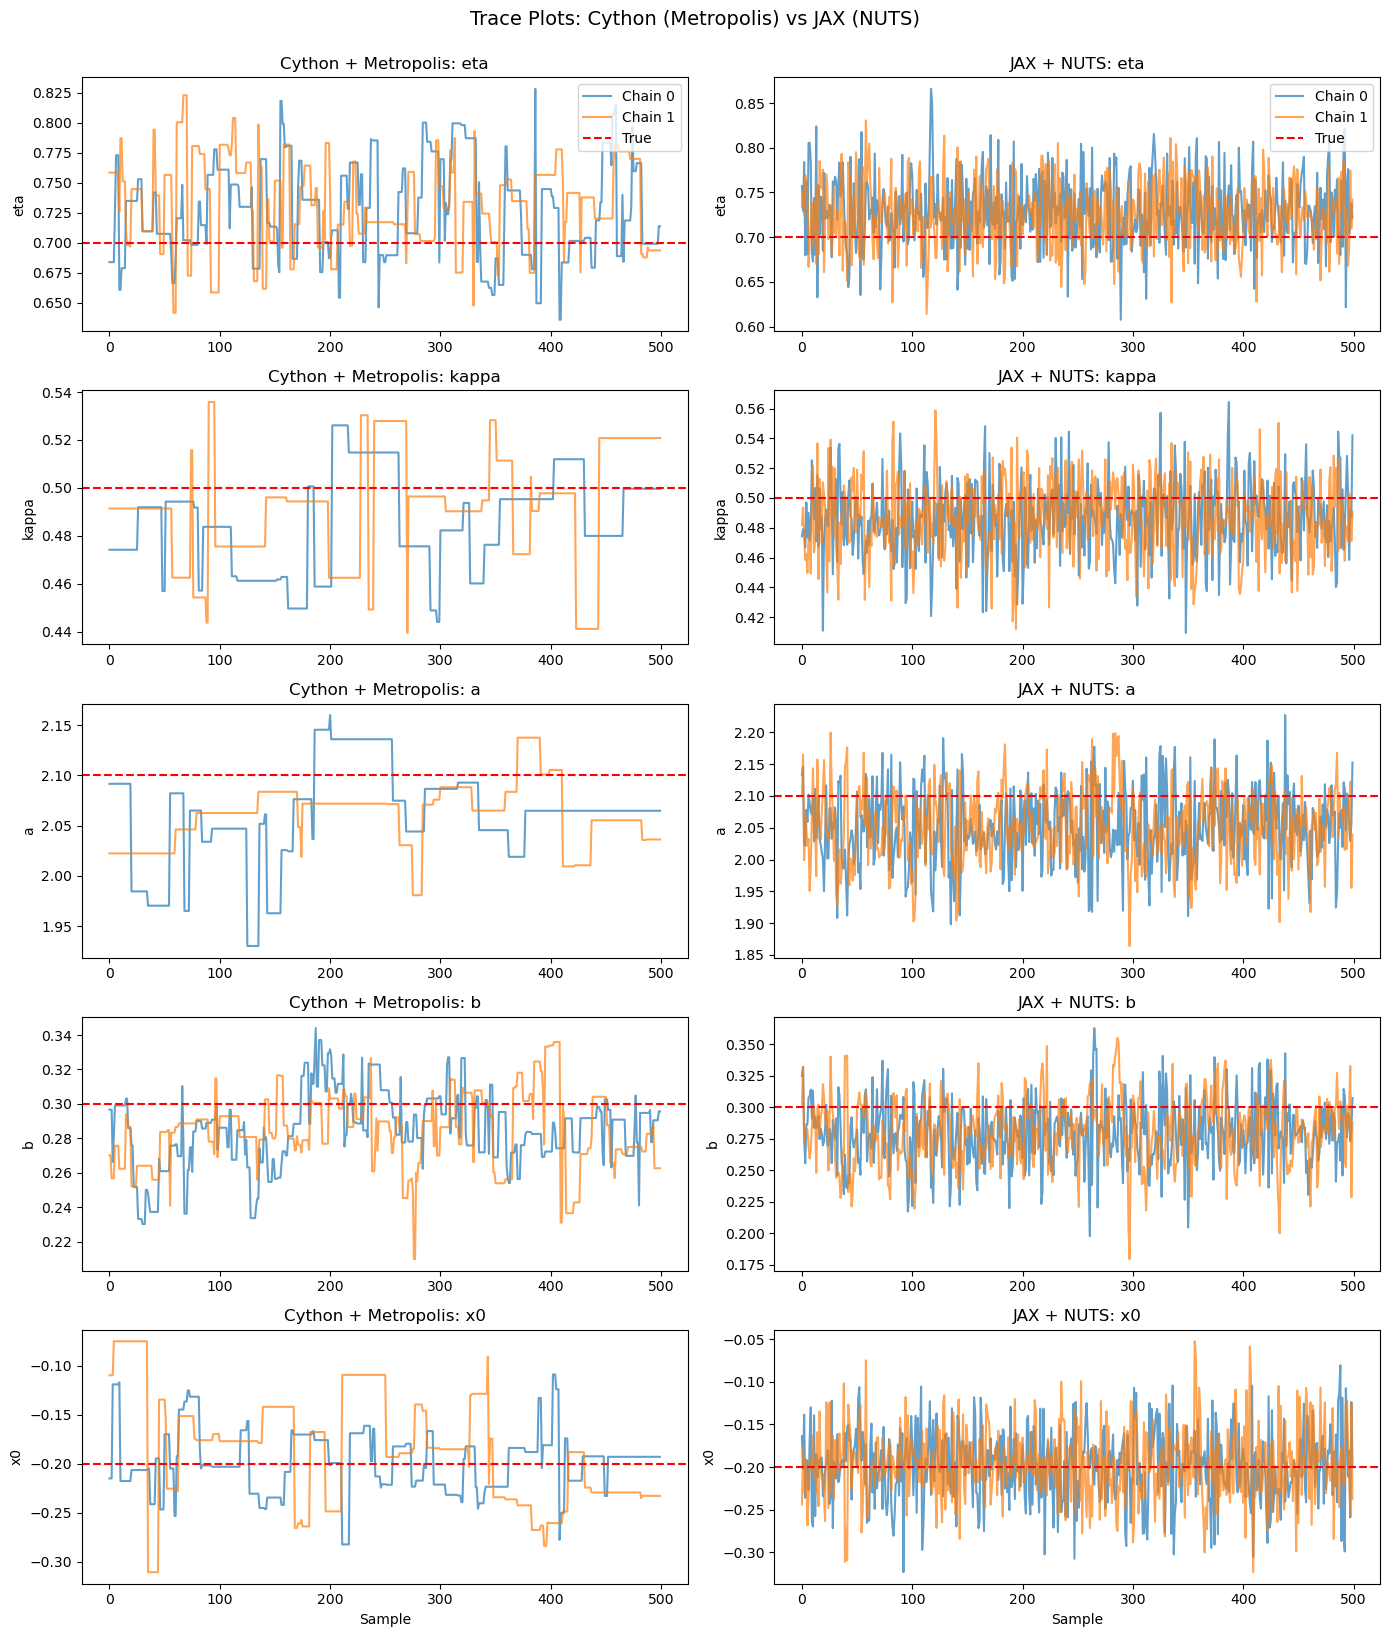

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(14, 16))

for i, param in enumerate(params):
    # Trace plot - Cython
    ax_cy = axes[i, 0]
    for chain in range(N_CHAINS):
        ax_cy.plot(trace_cython_renamed.posterior[param].sel(chain=chain).values, 
                   alpha=0.7, label=f'Chain {chain}')
    ax_cy.axhline(TRUE_PARAMS[param], color='red', linestyle='--', label='True')
    ax_cy.set_ylabel(param)
    ax_cy.set_title(f'Cython + Metropolis: {param}')
    if i == 0:
        ax_cy.legend(loc='upper right')
    
    # Trace plot - JAX
    ax_jax = axes[i, 1]
    for chain in range(N_CHAINS):
        ax_jax.plot(trace_jax_renamed.posterior[param].sel(chain=chain).values,
                    alpha=0.7, label=f'Chain {chain}')
    ax_jax.axhline(TRUE_PARAMS[param], color='red', linestyle='--', label='True')
    ax_jax.set_ylabel(param)
    ax_jax.set_title(f'JAX + NUTS: {param}')
    if i == 0:
        ax_jax.legend(loc='upper right')

axes[-1, 0].set_xlabel('Sample')
axes[-1, 1].set_xlabel('Sample')

plt.tight_layout()
plt.suptitle('Trace Plots: Cython (Metropolis) vs JAX (NUTS)', y=1.02, fontsize=14)
plt.show()

array([[<Axes: ylabel='kappa'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='eta', ylabel='x0'>, <Axes: xlabel='kappa'>,
        <Axes: xlabel='a'>, <Axes: xlabel='b'>]], dtype=object)

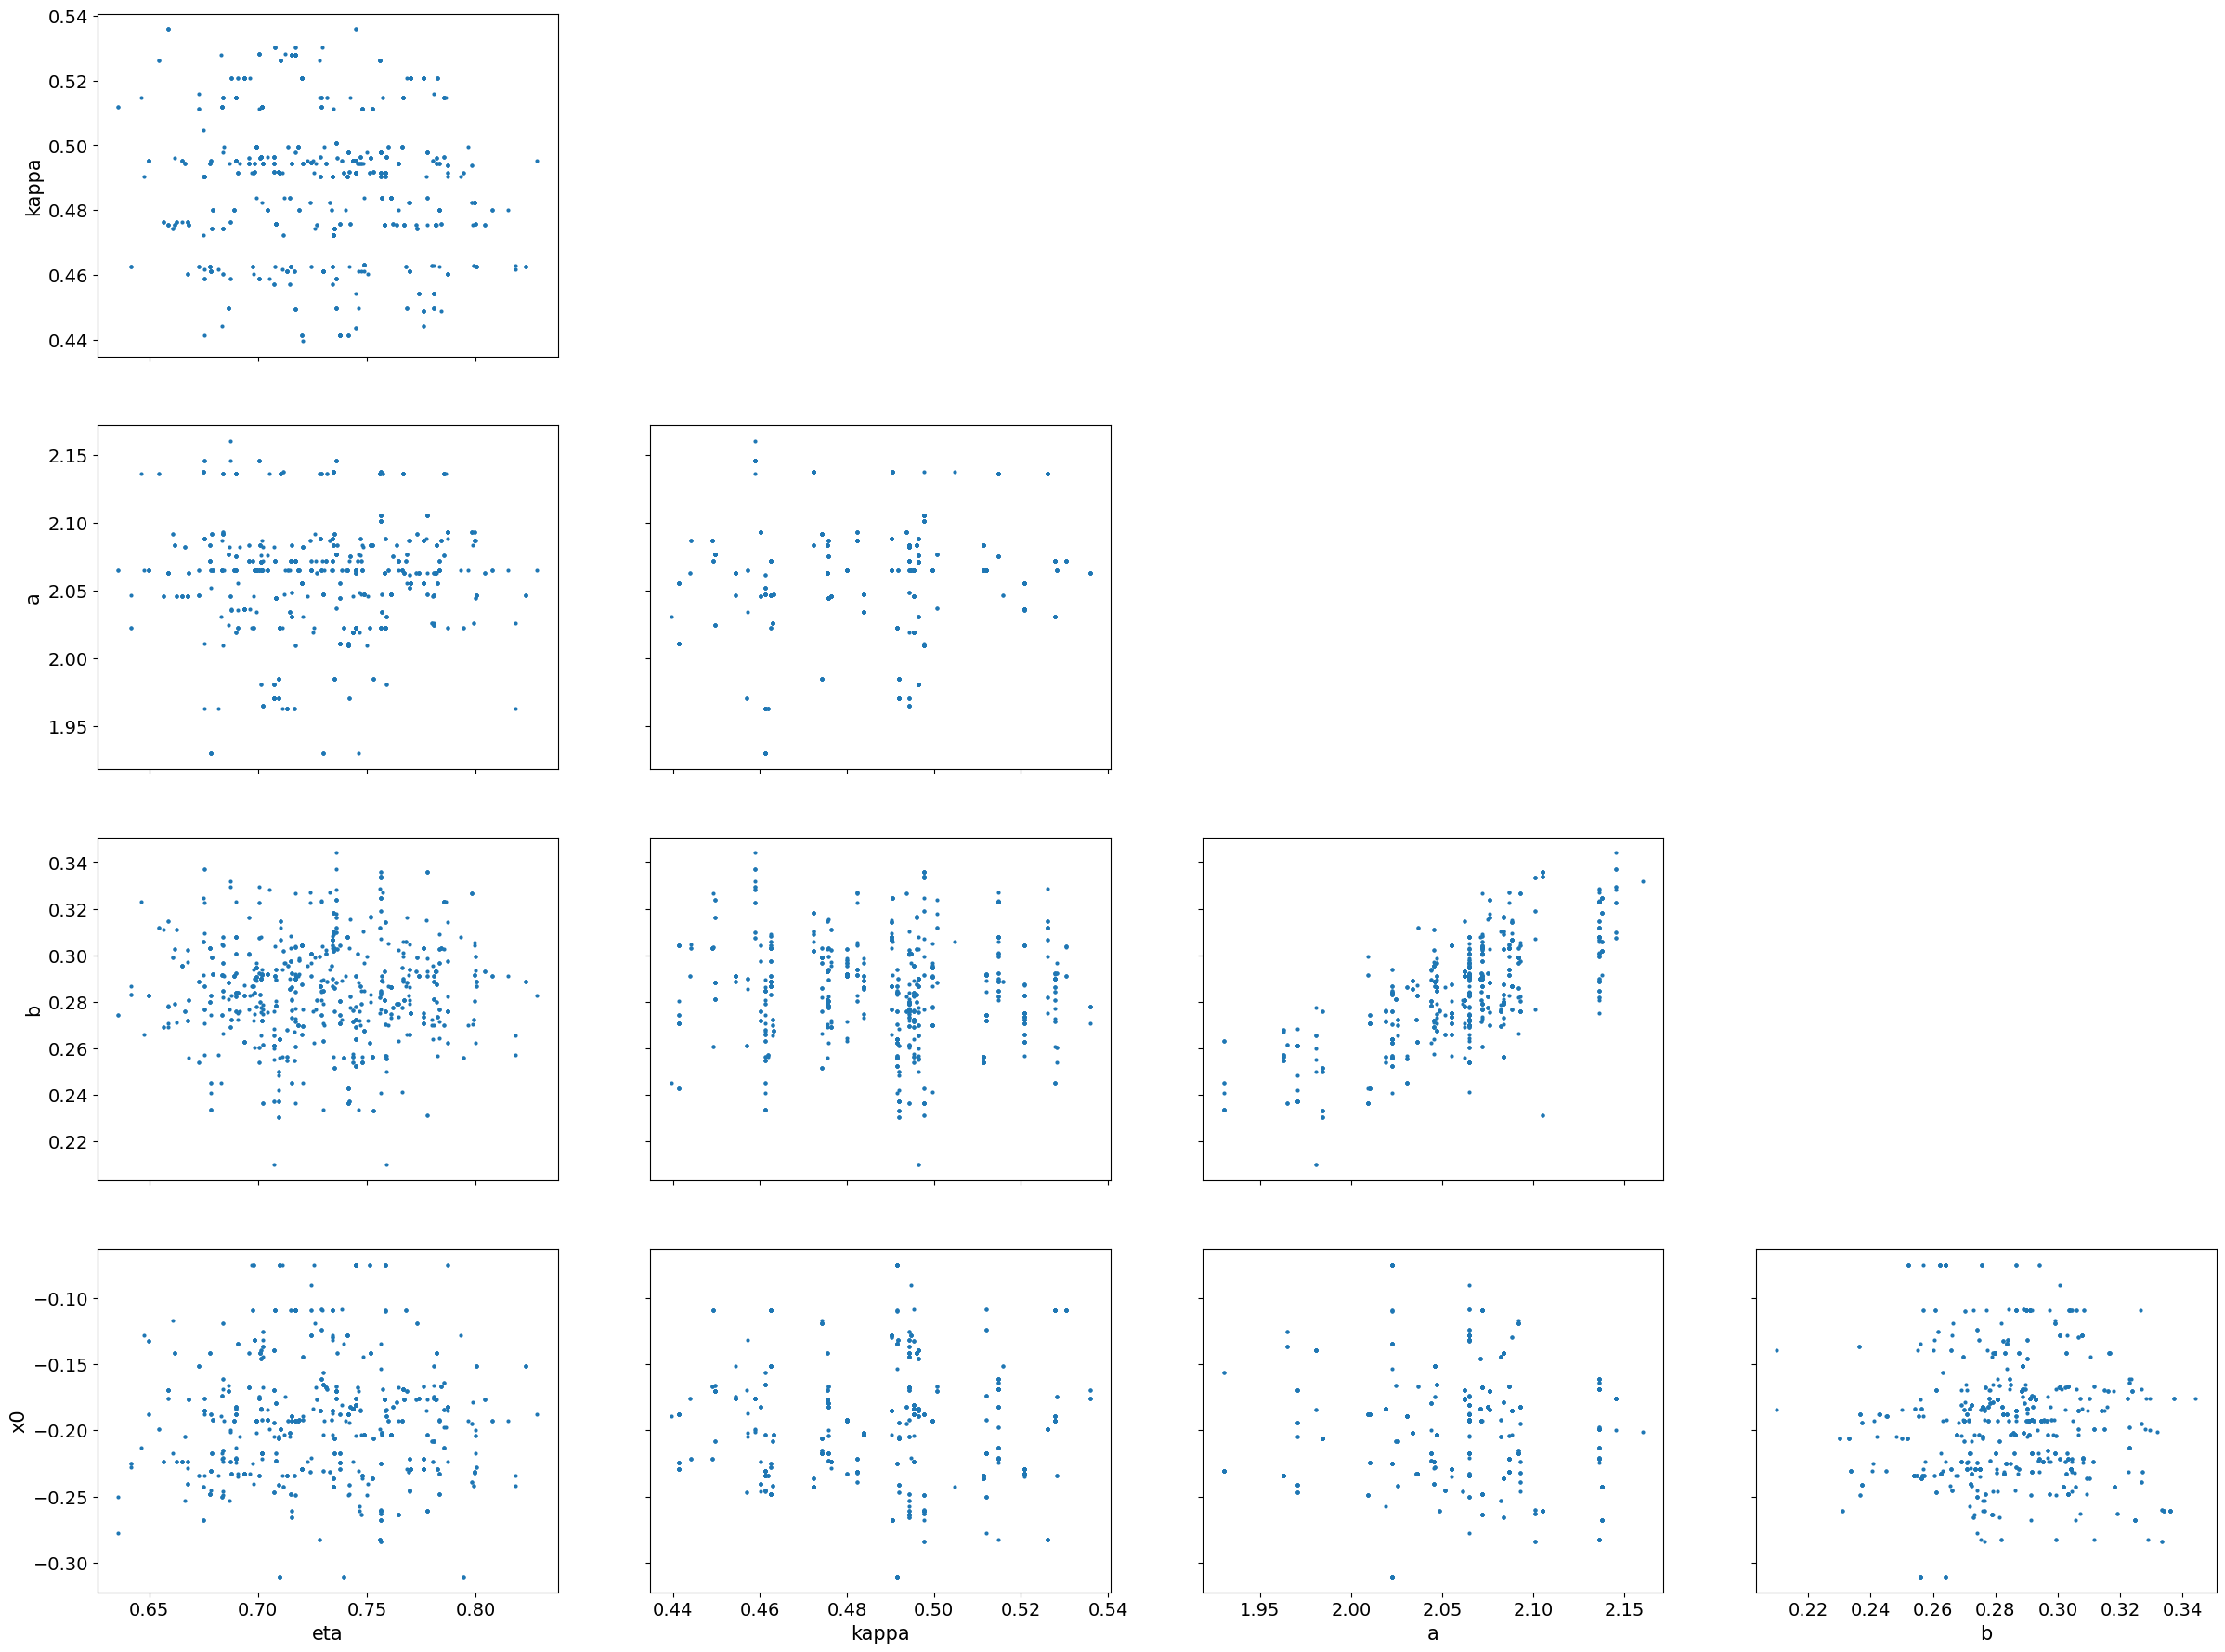

In [21]:
az.plot_pair(trace_cython_renamed, var_names=params)

array([[<Axes: ylabel='kappa'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='b'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='eta', ylabel='x0'>, <Axes: xlabel='kappa'>,
        <Axes: xlabel='a'>, <Axes: xlabel='b'>]], dtype=object)

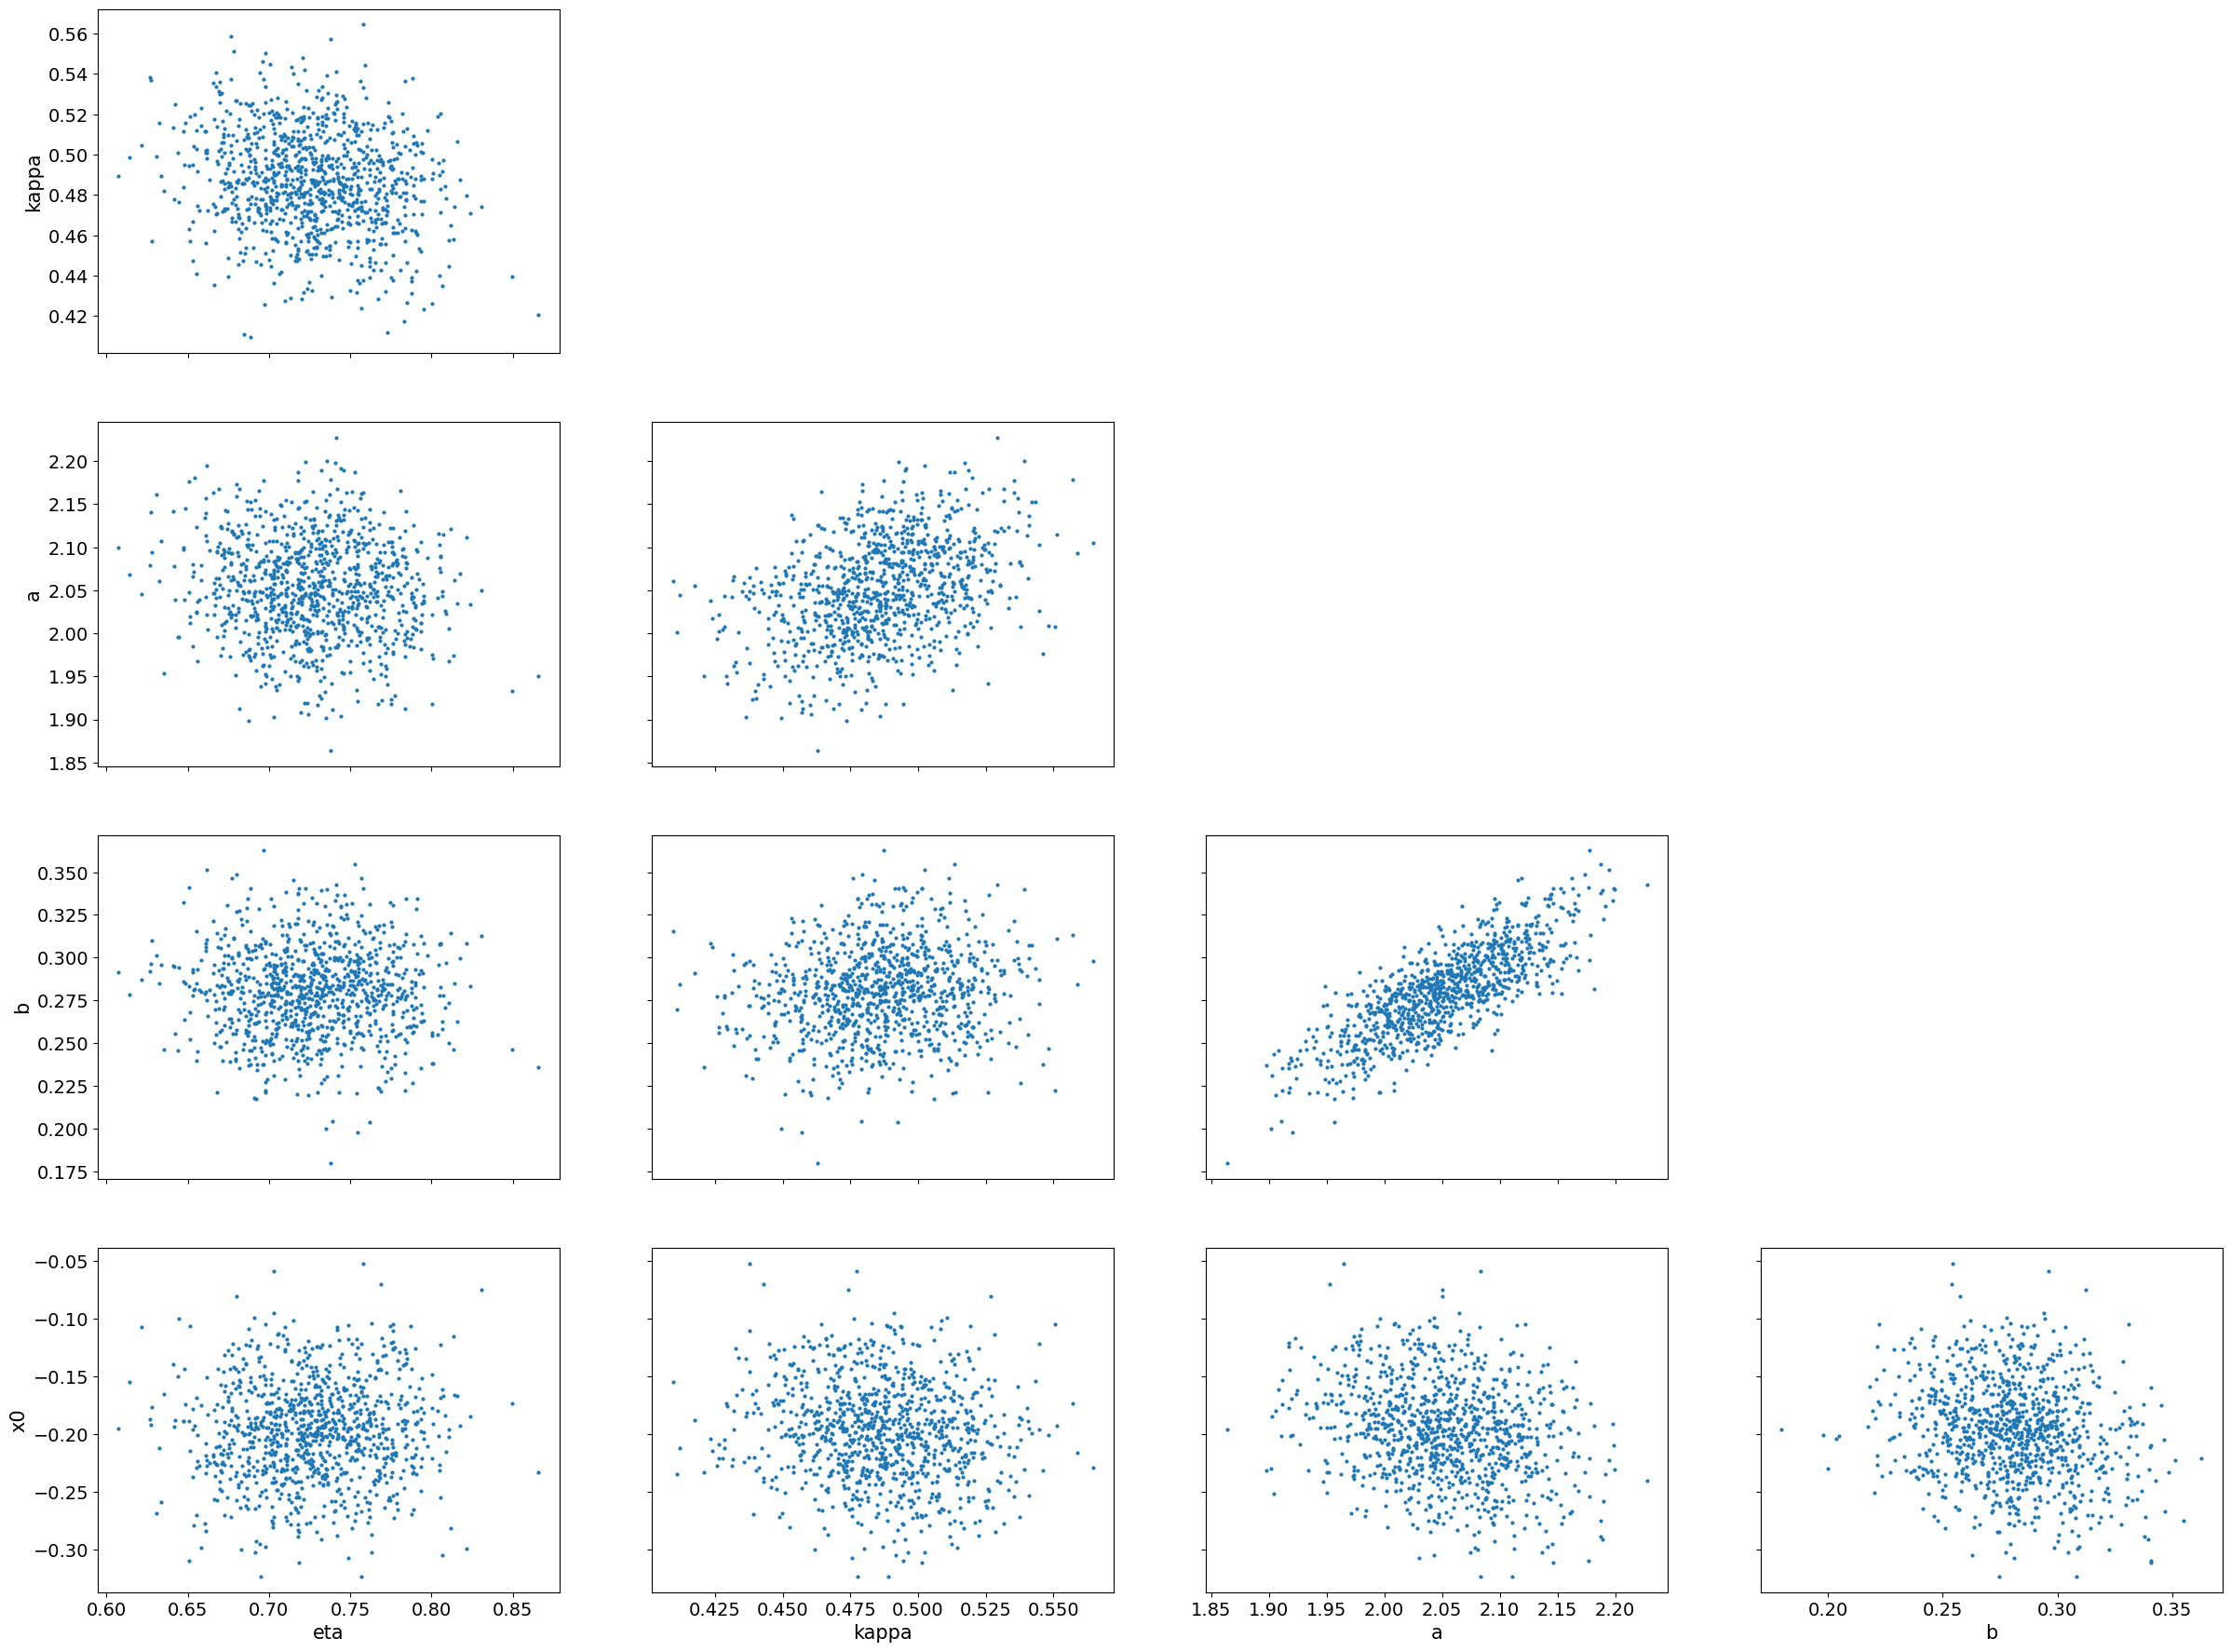

In [22]:
az.plot_pair(trace_jax_renamed, var_names=params)

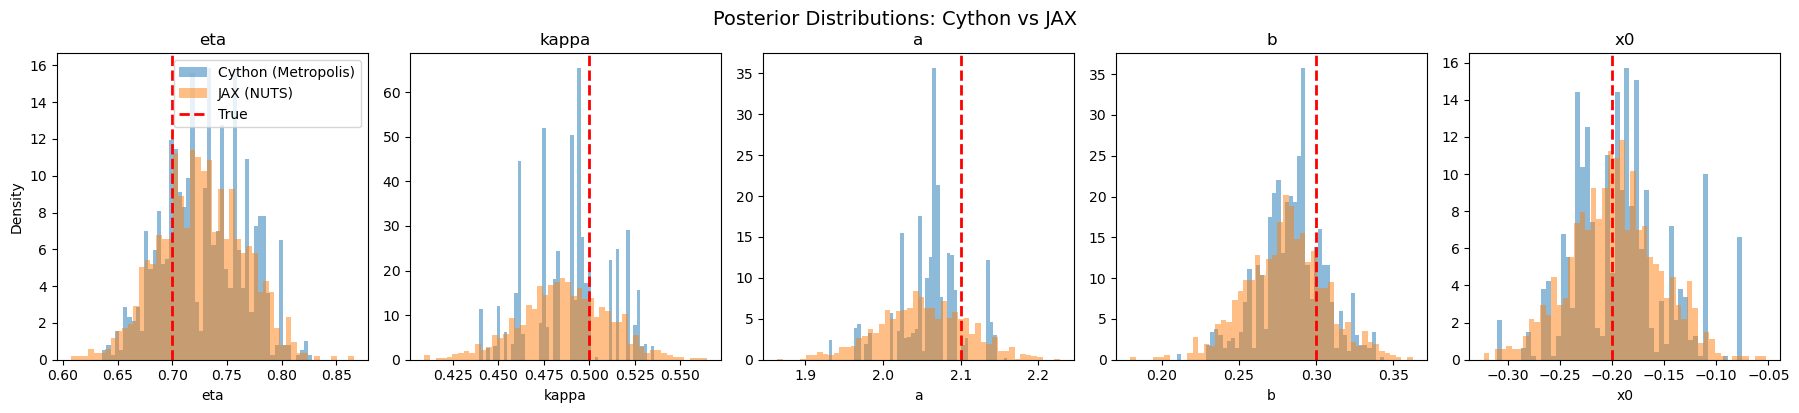

In [18]:
# Posterior comparison
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for i, param in enumerate(params):
    ax = axes[i]
    
    # Cython posterior
    cy_samples = trace_cython_renamed.posterior[param].values.flatten()
    ax.hist(cy_samples, bins=50, alpha=0.5, density=True, label='Cython (Metropolis)')
    
    # JAX posterior
    jax_samples = trace_jax_renamed.posterior[param].values.flatten()
    ax.hist(jax_samples, bins=50, alpha=0.5, density=True, label='JAX (NUTS)')
    
    # True value
    ax.axvline(TRUE_PARAMS[param], color='red', linestyle='--', linewidth=2, label='True')
    
    ax.set_xlabel(param)
    ax.set_ylabel('Density' if i == 0 else '')
    ax.set_title(param)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle('Posterior Distributions: Cython vs JAX', y=1.02, fontsize=14)
plt.show()

In [19]:
# ArviZ summary
print("\n" + "=" * 60)
print("Cython + Metropolis Summary")
print("=" * 60)
print(az.summary(trace_cython_renamed, var_names=params))


Cython + Metropolis Summary
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
eta    0.730  0.038   0.657    0.787      0.003    0.002     143.0     122.0   
kappa  0.489  0.022   0.450    0.528      0.003    0.002      45.0      49.0   
a      2.061  0.041   1.984    2.145      0.007    0.012      30.0      52.0   
b      0.285  0.021   0.252    0.336      0.003    0.003      58.0      80.0   
x0    -0.192  0.046  -0.267   -0.109      0.012    0.010      16.0      22.0   

       r_hat  
eta     1.04  
kappa   1.05  
a       1.22  
b       1.04  
x0      1.19  


In [20]:
print("\n" + "=" * 60)
print("JAX + NUTS Summary")
print("=" * 60)
print(az.summary(trace_jax_renamed, var_names=params))


JAX + NUTS Summary
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
eta    0.727  0.039   0.655    0.795      0.001    0.001    1190.0     779.0   
kappa  0.487  0.025   0.436    0.529      0.001    0.001    1028.0     737.0   
a      2.051  0.057   1.950    2.165      0.002    0.002     535.0     578.0   
b      0.280  0.026   0.234    0.333      0.001    0.001     480.0     428.0   
x0    -0.197  0.042  -0.278   -0.120      0.001    0.001    1185.0     680.0   

       r_hat  
eta      1.0  
kappa    1.0  
a        1.0  
b        1.0  
x0       1.0  


## 9. Summary

### Key Takeaways:

1. **JAX enables NUTS sampling**: Because the JAX implementation provides gradients via autodiff, we can use the NUTS sampler, which is generally much more efficient than Metropolis-Hastings.

2. **Effective Samples per Second**: NUTS typically achieves much higher effective sample size (ESS) per unit time because it makes more efficient use of gradient information to explore the posterior.

3. **Mixing**: NUTS chains typically mix better (lower autocorrelation) than Metropolis chains, especially for correlated parameters.

4. **Tuning**: NUTS automatically tunes the step size and tree depth during the warmup phase, while Metropolis requires manual tuning or relies on simple adaptive schemes.

### When to use each:

- **Cython + Metropolis**: When you need maximum single-evaluation speed and can afford many more samples, or when gradients are unavailable.

- **JAX + NUTS**: When you want efficient sampling and can leverage gradient information. This is typically the better choice for modern Bayesian inference.